In [1]:
import os
import glob
import pandas as pd

def find_mismatch_sequences(root_dir, verbose=True):
 
    records = []

    actions = [a for a in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, a))]
    if len(actions) == 0:
        print("Không tìm thấy action folder nào.")
        return pd.DataFrame()

    for action in actions:
        img_root = os.path.join(root_dir, action, "images_resized")
        kp_root  = os.path.join(root_dir, action, "keypoints")

        if not os.path.isdir(img_root) or not os.path.isdir(kp_root):
            continue

        seqs = [s for s in os.listdir(img_root) if os.path.isdir(os.path.join(img_root, s))]
        for seq in seqs:
            img_dir = os.path.join(img_root, seq)
            kp_dir  = os.path.join(kp_root, seq)

            imgs = sorted(glob.glob(os.path.join(img_dir, "*.jpg"))) + sorted(glob.glob(os.path.join(img_dir, "*.png")))
            kps  = sorted(glob.glob(os.path.join(kp_dir, "*.json"))) if os.path.isdir(kp_dir) else []

            n_img, n_kp = len(imgs), len(kps)
            diff = abs(n_img - n_kp)
            records.append([action, seq, n_img, n_kp, diff])

    df = pd.DataFrame(records, columns=["action", "sequence", "n_images", "n_keypoints", "diff"])

    bad_df = df[df["diff"] > 0].reset_index(drop=True)

    if verbose:
        print(f"Tổng sequence kiểm tra: {len(df)}")
        print(f"Phát hiện {len(bad_df)} sequence lệch số lượng ảnh/keypoint\n")
        if len(bad_df) > 0:
            display(bad_df.head(20))
        else:
            print("✅ Tất cả sequence đều khớp số lượng.")

    
    return bad_df

In [2]:
ROOT_DIR = "/kaggle/input/data2711-morning/data_estiomation"
# do là đã tạo dữ liệu clean rồi nên không cần phải chạy lại miss kp
# mismatch_df = find_mismatch_sequences(ROOT_DIR)
# mismatch_df.to_csv("/kaggle/working/mismatch_sequences.csv", index=False)

In [3]:
import os, shutil
from tqdm import tqdm

def copy_clean_sequences(root_dir, dest_dir, bad_df):
    
    os.makedirs(dest_dir, exist_ok=True)

    bad_pairs = set((a, s) for a, s in zip(bad_df["action"], bad_df["sequence"]))

    actions = [a for a in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, a))]
    for action in actions:
        img_src = os.path.join(root_dir, action, "images_resized")
        kp_src  = os.path.join(root_dir, action, "keypoints")
        img_dst = os.path.join(dest_dir, action, "images_resized")
        kp_dst  = os.path.join(dest_dir, action, "keypoints")

        os.makedirs(img_dst, exist_ok=True)
        os.makedirs(kp_dst,  exist_ok=True)

        seqs = [s for s in os.listdir(img_src) if os.path.isdir(os.path.join(img_src, s))]
        for seq in tqdm(seqs, desc=f"Copy {action}"):
            if (action, seq) in bad_pairs:
                continue  

            src_img_dir = os.path.join(img_src, seq)
            src_kp_dir  = os.path.join(kp_src, seq)
            dst_img_dir = os.path.join(img_dst, seq)
            dst_kp_dir  = os.path.join(kp_dst, seq)

            
            shutil.copytree(src_img_dir, dst_img_dir)
            if os.path.isdir(src_kp_dir):
                shutil.copytree(src_kp_dir, dst_kp_dir)

    print(f"Đã tạo dataset sạch tại: {dest_dir}")

In [4]:
# clean_root = "/kaggle/working/data_estiomation"
# copy_clean_sequences(
#     root_dir="/kaggle/input/data2711-morning/data_estiomation",
#     dest_dir=clean_root,
#     bad_df=mismatch_df
# )

In [5]:
import os, glob, json, math, random, time, shutil
from typing import List, Tuple, Literal, Optional

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# ==== Config  ====
ROOT_DIR   = "/kaggle/input/data2711-morning/data_estiomation"  
ACTIONS    = ['CLIMB','FALL','LIEDOWN','SIT','STAND']
SEQ_LEN    = 24
IMG_SIZE   = 224
BATCH_SIZE = 4
LR         = 1e-4
SEED       = 42

AUTOTUNE = tf.data.AUTOTUNE
rng_np   = np.random.default_rng(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("ROOT_DIR:", ROOT_DIR)
print("ACTIONS:", ACTIONS)


2025-12-02 12:52:24.147083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764679944.354592      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764679944.414092      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

ROOT_DIR: /kaggle/input/data2711-morning/data_estiomation
ACTIONS: ['CLIMB', 'FALL', 'LIEDOWN', 'SIT', 'STAND']


In [6]:
def check_dataset_structure(root_dir: str):
    print(f"Kiểm tra thư mục gốc: {root_dir}\n")

    if not os.path.isdir(root_dir):
        print("Không tìm thấy thư mục gốc!")
        return False
    actions = [a for a in sorted(os.listdir(root_dir)) 
               if os.path.isdir(os.path.join(root_dir, a))]
    if len(actions) == 0:
        print("Không có action folder nào trong thư mục gốc.")
        return False

    print(f"Phát hiện {len(actions)} action folders: {actions}\n")

    total_seq_all = 0
    total_img_all = 0
    total_kp_all  = 0

    for action in actions:
        act_path = os.path.join(root_dir, action)
        img_root = os.path.join(act_path, "images_resized")
        kp_root  = os.path.join(act_path, "keypoints")

        if not os.path.isdir(img_root):
            print(f"{action}: thiếu 'images_resized'")
            continue
        if not os.path.isdir(kp_root):
            print(f"{action}: thiếu 'keypoints'")
            continue

        seqs = [s for s in os.listdir(img_root)
                if os.path.isdir(os.path.join(img_root, s))]
        total_seq_all += len(seqs)
        print(f"{action}: {len(seqs)} sequences")

        total_img = 0
        total_kp  = 0
        mismatched = 0

        for seq in seqs:
            img_dir = os.path.join(img_root, seq)
            kp_dir  = os.path.join(kp_root,  seq)

            imgs = glob.glob(os.path.join(img_dir, "*.jpg")) \
                 + glob.glob(os.path.join(img_dir, "*.png"))
            kps  = glob.glob(os.path.join(kp_dir,  "*.json"))

            total_img += len(imgs)
            total_kp  += len(kps)
            if len(imgs) != len(kps):
                mismatched += 1

        total_img_all += total_img
        total_kp_all  += total_kp

        print(f"   ├─ Tổng ảnh     : {total_img:5d}")
        print(f"   ├─ Tổng keypoints: {total_kp:5d}")
        print(f"   └─ Trung bình   : {total_img/max(1,len(seqs)):.1f} ảnh/seq, "
              f"{total_kp/max(1,len(seqs)):.1f} kp/seq")
        if mismatched > 0:
            print(f"   {mismatched} sequences không khớp số ảnh/kp.")
        print()

    print("Tổng hợp toàn bộ dataset:")
    print(f"   ├─ Tổng action  : {len(actions)}")
    print(f"   ├─ Tổng sequence: {total_seq_all}")
    print(f"   ├─ Tổng ảnh     : {total_img_all}")
    print(f"   └─ Tổng keypoints: {total_kp_all}")
    print("\nHoàn tất kiểm tra cấu trúc dataset.")
    return True

_ = check_dataset_structure(ROOT_DIR)

Kiểm tra thư mục gốc: /kaggle/input/data2711-morning/data_estiomation

Phát hiện 5 action folders: ['CLIMB', 'FALL', 'LIEDOWN', 'SIT', 'STAND']

CLIMB: 86 sequences
   ├─ Tổng ảnh     :  2686
   ├─ Tổng keypoints:  2685
   └─ Trung bình   : 31.2 ảnh/seq, 31.2 kp/seq
   1 sequences không khớp số ảnh/kp.

FALL: 133 sequences
   ├─ Tổng ảnh     :  2786
   ├─ Tổng keypoints:  2786
   └─ Trung bình   : 20.9 ảnh/seq, 20.9 kp/seq

LIEDOWN: 103 sequences
   ├─ Tổng ảnh     :  2528
   ├─ Tổng keypoints:  2528
   └─ Trung bình   : 24.5 ảnh/seq, 24.5 kp/seq

SIT: 178 sequences
   ├─ Tổng ảnh     :  6769
   ├─ Tổng keypoints:  6769
   └─ Trung bình   : 38.0 ảnh/seq, 38.0 kp/seq
   2 sequences không khớp số ảnh/kp.

STAND: 206 sequences
   ├─ Tổng ảnh     :  7544
   ├─ Tổng keypoints:  7542
   └─ Trung bình   : 36.6 ảnh/seq, 36.6 kp/seq
   2 sequences không khớp số ảnh/kp.

Tổng hợp toàn bộ dataset:
   ├─ Tổng action  : 5
   ├─ Tổng sequence: 706
   ├─ Tổng ảnh     : 22313
   └─ Tổng keypoints: 223

In [7]:
def uniform_indices(n: int, T: int = SEQ_LEN) -> List[int]:
    if n <= 0:
        return []
    if n == T:
        return list(range(n))
    if n > T:
        return [int(round(i*(n-1)/(T-1))) for i in range(T)]
    return list(range(n))

def random_window_uniform_indices(
    n: int,
    T: int = SEQ_LEN,
    window_ratio: float = 0.85,
    rng: Optional[np.random.Generator] = None
) -> List[int]:
    if n <= 0:
        return []
        
    if n <= T:
        return list(range(n))
    if rng is None:
        rng = np.random.default_rng()
    W = max(T, int(round(window_ratio * n)))
    W = min(W, n)
    start_max = n - W
    start = int(rng.integers(0, start_max + 1)) if start_max > 0 else 0
    end = start + W - 1
    return [int(round(start + i*(W-1)/(T-1))) for i in range(T)]

def pad_indices(
    n: int,
    T: int = SEQ_LEN,
    mode: Literal["replicate", "loop"] = "replicate",
    loop_tail: int = 2
) -> List[int]:
    
    idx = list(range(n))
    if n == 0:
        return [0] * T
    if n >= T:
        return idx[:T]

    if mode == "replicate":
        idx += [n-1] * (T - n)
    else:
        tail = list(range(max(0, n - loop_tail), n)) or [n-1]
        while len(idx) < T:
            idx += tail
        idx = idx[:T]
    return idx

def ffill_bfill_kps(kps: np.ndarray) -> np.ndarray:
    
    if kps.size == 0:
        return kps
    T = kps.shape[0]
    valid = np.any(kps != 0, axis=1)
    if not valid[0] and np.any(valid):
        first = np.argmax(valid)
        kps[:first] = kps[first]
    last = kps[0].copy()
    for t in range(T):
        if np.any(kps[t] != 0):
            last = kps[t]
        else:
            kps[t] = last
    return kps

def read_seq_paths(img_dir: str, kp_dir: str) -> Tuple[List[str], List[str]]:
    imgs = sorted(glob.glob(os.path.join(img_dir, "*.jpg"))
                  + glob.glob(os.path.join(img_dir, "*.png")))
    kps  = sorted(glob.glob(os.path.join(kp_dir,  "*.json")))
    n = min(len(imgs), len(kps))
    return imgs[:n], kps[:n]

def load_seq_24(
    img_paths: List[str],
    kp_paths: List[str],
    img_size: int = IMG_SIZE,
    mode: Literal["train","val","test"] = "train",
    window_ratio: float = 0.85,
    pad_mode: Literal["replicate","loop"] = "replicate",
    loop_tail: int = 2,
    rng: Optional[np.random.Generator] = rng_np
) -> Tuple[np.ndarray, np.ndarray]:

    if len(img_paths) == 0 or len(kp_paths) == 0:
        return (np.zeros((SEQ_LEN, img_size, img_size, 3), np.float32),
                np.zeros((SEQ_LEN, 75), np.float32))

    first = cv2.imread(img_paths[0])
    if first is None:
        return (np.zeros((SEQ_LEN, img_size, img_size, 3), np.float32),
                np.zeros((SEQ_LEN, 75), np.float32))

    H, W = first.shape[:2]
    n = min(len(img_paths), len(kp_paths))
    img_paths = img_paths[:n]
    kp_paths  = kp_paths[:n]

    if n > SEQ_LEN:
        sel = uniform_indices(n, SEQ_LEN)
    else:
        sel = list(range(n))

    frames, keyps = [], []
    for i in sel:
        im = cv2.imread(img_paths[i])
        if im is None:
            im = first.copy()

        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (img_size, img_size))
        frames.append(im.astype(np.float32)/255.0)

        with open(kp_paths[i], "r") as f:
            jd = json.load(f)
        if "people" in jd and jd["people"] and "pose_keypoints_2d" in jd["people"][0]:
            arr = np.array(jd["people"][0]["pose_keypoints_2d"], dtype=np.float32).reshape(-1, 3)
        else:
            arr = np.zeros((25, 3), dtype=np.float32)

        if W > 0 and H > 0:
            arr[:,0] /= float(W)
            arr[:,1] /= float(H)
        keyps.append(arr.reshape(-1))  

    frames = np.stack(frames, axis=0)  
    keyps  = np.stack(keyps,  axis=0)
    m = frames.shape[0]

    if m < SEQ_LEN:
        pidx = pad_indices(m, SEQ_LEN, mode=pad_mode, loop_tail=loop_tail)
        frames = frames[pidx[:SEQ_LEN]]
        keyps  = keyps[pidx[:SEQ_LEN]]

    keyps = ffill_bfill_kps(keyps)

    frames = frames[:SEQ_LEN]
    keyps  = keyps[:SEQ_LEN]

    return frames.astype(np.float32), keyps.astype(np.float32)

print("Sampling & padding utils ready.")


Sampling & padding utils ready.


In [8]:
def list_sequences(root_dir: str, actions: List[str]) -> List[Tuple[str,str,str]]:

    items = []
    for act in actions:
        img_root = os.path.join(root_dir, act, "images_resized")
        kp_root  = os.path.join(root_dir, act, "keypoints")
        if not (os.path.isdir(img_root) and os.path.isdir(kp_root)):
            continue
        for seq in sorted(os.listdir(img_root)):
            img_dir = os.path.join(img_root, seq)
            kp_dir  = os.path.join(kp_root, seq)
            if os.path.isdir(img_dir) and os.path.isdir(kp_dir):
                imgs = glob.glob(os.path.join(img_dir, "*.jpg")) \
                     + glob.glob(os.path.join(img_dir, "*.png"))
                kps  = glob.glob(os.path.join(kp_dir,  "*.json"))
                if len(imgs) == 0 or len(kps) == 0:
                    continue
                items.append((act, img_dir, kp_dir))
    return items

def split_items(items, train_ratio=0.7, val_ratio=0.15, seed=SEED):
    rng = np.random.default_rng(seed)
    items = items.copy()
    rng.shuffle(items)
    n = len(items)
    tr = int(train_ratio * n)
    va = int((train_ratio + val_ratio) * n)
    return items[:tr], items[tr:va], items[va:]

class2idx = {a:i for i,a in enumerate(ACTIONS)}

def seq_gen(items, mode="train"):
    for act, img_dir, kp_dir in items:
        img_paths, kp_paths = read_seq_paths(img_dir, kp_dir)
        frames, kps = load_seq_24(
            img_paths, kp_paths,
            img_size=IMG_SIZE,
            mode=mode,
            window_ratio=0.85,
            pad_mode="replicate",
            loop_tail=2,
            rng=rng_np
        )
        y = to_categorical(class2idx[act], num_classes=len(ACTIONS)).astype(np.float32)
        yield {"images": frames, "keypoints": kps}, y

output_signature = (
    {
        "images":    tf.TensorSpec(shape=(SEQ_LEN, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        "keypoints": tf.TensorSpec(shape=(SEQ_LEN, 75), dtype=tf.float32),
    },
    tf.TensorSpec(shape=(len(ACTIONS),), dtype=tf.float32),
)

def make_fusion_ds(items, mode="train", batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_generator(
        lambda: seq_gen(items, mode=mode),
        output_signature=output_signature
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=min(2048, len(items)*2), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=False).prefetch(AUTOTUNE)
    return ds


all_items = list_sequences(ROOT_DIR, ACTIONS)
train_items, val_items, test_items = split_items(all_items, 0.7, 0.15, SEED)

train_fusion_ds = make_fusion_ds(train_items, mode="train", shuffle=True)
val_fusion_ds   = make_fusion_ds(val_items,   mode="val",   shuffle=False)
test_fusion_ds  = make_fusion_ds(test_items,  mode="test",  shuffle=False)

print(f"Sequences -> train: {len(train_items)} | val: {len(val_items)} | test: {len(test_items)}")
print("Batches   -> train:", sum(1 for _ in train_fusion_ds),
      "| val:",   sum(1 for _ in val_fusion_ds),
      "| test:",  sum(1 for _ in test_fusion_ds))

xb, yb = next(iter(train_fusion_ds))
print("Sanity batch shapes:")
print("  images   :", xb["images"].shape)
print("  keypoints:", xb["keypoints"].shape)
print("  labels   :", yb.shape)


train_labels = [class2idx[a] for a,_,_ in train_items]
cnt = Counter(train_labels)
print("Class distribution (train):", {ACTIONS[k]: v for k,v in cnt.items()})

I0000 00:00:1764679968.306400      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Sequences -> train: 494 | val: 106 | test: 106
Batches   -> train: 124 | val: 27 | test: 27
Sanity batch shapes:
  images   : (4, 24, 224, 224, 3)
  keypoints: (4, 24, 75)
  labels   : (4, 5)
Class distribution (train): {'STAND': 134, 'FALL': 96, 'SIT': 124, 'LIEDOWN': 77, 'CLIMB': 63}


In [9]:
def make_img_ds(base_ds):
    return base_ds.map(lambda x, y: (x["images"], y))
    
def make_kp_ds(base_ds):
    return base_ds.map(lambda x, y: (x["keypoints"], y))
    
def make_fusion_ds_from(base_ds):
    return base_ds  
    
train_img_ds   = make_img_ds(train_fusion_ds)
val_img_ds     = make_img_ds(val_fusion_ds)
test_img_ds    = make_img_ds(test_fusion_ds)
    
train_kp_ds    = make_kp_ds(train_fusion_ds)
val_kp_ds      = make_kp_ds(val_fusion_ds)
test_kp_ds     = make_kp_ds(test_fusion_ds)


train_fusion_ds = make_fusion_ds_from(train_fusion_ds)
val_fusion_ds   = make_fusion_ds_from(val_fusion_ds)
test_fusion_ds  = make_fusion_ds_from(test_fusion_ds)
    
  
xi, yi = next(iter(train_img_ds))
xk, yk = next(iter(train_kp_ds))
xf, yf = next(iter(train_fusion_ds))
    
print("img_ds batch:", xi.shape, yi.shape)
print("kp_ds batch :", xk.shape, yk.shape)
print("fusion batch:", xf["images"].shape, xf["keypoints"].shape, yf.shape)


img_ds batch: (4, 24, 224, 224, 3) (4, 5)
kp_ds batch : (4, 24, 75) (4, 5)
fusion batch: (4, 24, 224, 224, 3) (4, 24, 75) (4, 5)


In [10]:
train_label_ids = [class2idx[a] for a,_,_ in train_items]
counts = Counter(train_label_ids)

n_total = sum(counts.values())

class_weights = {
    i: n_total / (len(ACTIONS) * counts.get(i, 1))
    for i in range(len(ACTIONS))
}
print("Class weights:", {ACTIONS[i]: round(w,3) for i,w in class_weights.items()})


Class weights: {'CLIMB': 1.568, 'FALL': 1.029, 'LIEDOWN': 1.283, 'SIT': 0.797, 'STAND': 0.737}


In [11]:
NUM_CLASSES = len(ACTIONS)

def build_img_model(img_size=IMG_SIZE, seq_len=SEQ_LEN, num_classes=NUM_CLASSES, alpha=0.5, lr=LR):
    img_in = layers.Input(shape=(seq_len, img_size, img_size, 3), name="images")
    try:
        base = tf.keras.applications.MobileNetV2(
            input_shape=(img_size, img_size, 3),
            include_top=False,
            weights="imagenet",
            alpha=alpha
        )
        print("IMG backbone: MobileNetV2(weights='imagenet')")
    except Exception as e:
        print("Load ImageNet fail, dùng weights=None:", e)
        base = tf.keras.applications.MobileNetV2(
            input_shape=(img_size, img_size, 3),
            include_top=False,
            weights=None,
            alpha=alpha
        )
    base.trainable = False

    x = layers.TimeDistributed(base, name="td_mobilenet")(img_in)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D(), name="td_gap")(x)
    x = layers.LSTM(128, name="img_lstm")(x)
    x = layers.Dropout(0.3, name="img_dropout")(x)
    x = layers.Dense(128, activation="relu", name="img_dense")(x)
    x = layers.Dropout(0.3, name="img_dense_dropout")(x)
    out = layers.Dense(num_classes, activation="softmax", name="cls_head")(x)

    model = models.Model(inputs=img_in, outputs=out, name="img_only_model")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def build_kp_model(seq_len=SEQ_LEN, num_classes=NUM_CLASSES, lr=LR):
    kp_in = layers.Input(shape=(seq_len, 75), name="keypoints")

    x = layers.LSTM(128, return_sequences=True, name="kp_lstm1")(kp_in)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(128, name="kp_lstm2")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu", name="kp_dense")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax", name="cls_head")(x)

    model = models.Model(inputs=kp_in, outputs=out, name="kp_only_model")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


def build_fusion_model(img_size=IMG_SIZE, seq_len=SEQ_LEN, num_classes=NUM_CLASSES, alpha=0.5, lr=LR):
    img_in = layers.Input(shape=(seq_len, img_size, img_size, 3), name="images")
    try:
        base = tf.keras.applications.MobileNetV2(
            input_shape=(img_size, img_size, 3),
            include_top=False,
            weights="imagenet",
            alpha=alpha
        )
        print("FUSION backbone: MobileNetV2(weights='imagenet')")
    except Exception as e:
        print("Load ImageNet fail, dùng weights=None:", e)
        base = tf.keras.applications.MobileNetV2(
            input_shape=(img_size, img_size, 3),
            include_top=False,
            weights=None,
            alpha=alpha
        )
    base.trainable = False

    xi = layers.TimeDistributed(base, name="td_mobilenet")(img_in)
    xi = layers.TimeDistributed(layers.GlobalAveragePooling2D(), name="td_gap")(xi)
    xi = layers.LSTM(128, name="img_lstm")(xi)
    xi = layers.Dropout(0.3, name="img_dropout")(xi)

    kp_in = layers.Input(shape=(seq_len, 75), name="keypoints")
    xk = layers.LSTM(128, name="kp_lstm")(kp_in)
    xk = layers.Dropout(0.3, name="kp_dropout")(xk)

    # fusion
    h = layers.Concatenate(name="fusion_concat")([xi, xk])
    h = layers.Dense(128, activation="relu", name="fusion_dense")(h)
    h = layers.Dropout(0.3, name="fusion_dropout")(h)
    out = layers.Dense(num_classes, activation="softmax", name="cls_head")(h)

    model = models.Model(inputs=[img_in, kp_in], outputs=out, name="fusion_model")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


print("Model builders ready.")

Model builders ready.


In [12]:
import matplotlib.pyplot as plt

def plot_training_curves(history, title="Training Curves"):
    hist = history.history

    acc      = hist.get("accuracy", [])
    val_acc  = hist.get("val_accuracy", [])
    loss     = hist.get("loss", [])
    val_loss = hist.get("val_loss", [])

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(13, 5))

    # ACC
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, marker='o', linewidth=2)
    plt.plot(epochs, val_acc, marker='o', linewidth=2)
    plt.title(f"{title} — Accuracy", fontsize=14)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    plt.legend(["Train Acc", "Val Acc"])

    # LOSS
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, marker='o', linewidth=2)
    plt.plot(epochs, val_loss, marker='o', linewidth=2)
    plt.title(f"{title} — Loss", fontsize=14)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.legend(["Train Loss", "Val Loss"])

    plt.tight_layout()
    plt.show()
    

In [13]:
def banner(title: str):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

class PrettyEpochLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.best = 0.0
        self.t0   = time.time()
        header = f"{'Epoch':>5} | {'acc%':>7} | {'val_acc%':>9} | {'loss':>8} | {'val_loss':>9} | {'best%':>7} | {'time':>7}"
        print("\n" + header)
        print("-"*len(header))

    def on_epoch_end(self, e, logs=None):
        acc = (logs.get('accuracy') or 0)*100
        va  = (logs.get('val_accuracy') or 0)*100
        lo  = (logs.get('loss') or 0)
        vlo = (logs.get('val_loss') or 0)
        self.best = max(self.best, va)
        elapsed = time.time() - self.t0
        print(f"{e+1:5d} | {acc:7.2f} | {va:9.2f} | {lo:8.4f} | {vlo:9.4f} | {self.best:7.2f} | {elapsed:7.1f}s")

def train_model(model, train_ds, val_ds, class_weights, name="model"):
    cbs = [
        tf.keras.callbacks.EarlyStopping(
            patience=7, restore_best_weights=True, monitor='val_accuracy'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            patience=3, factor=0.5, min_lr=1e-6, monitor='val_accuracy'
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"{name}_best.weights.h5",
            save_best_only=True,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max'
        ),
        PrettyEpochLogger()
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        class_weight=class_weights,
        callbacks=cbs,
        verbose=0
    )
    return history



TRAIN IMG-ONLY
3201480/3201480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
IMG backbone: MobileNetV2(weights='imagenet')

Epoch |    acc% |  val_acc% |     loss |  val_loss |   best% |    time
----------------------------------------------------------------------


I0000 00:00:1764680457.547638     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


    1 |   42.31 |     71.70 |   1.3568 |    1.0059 |   71.70 |   179.2s
    2 |   68.62 |     77.36 |   0.8538 |    0.7292 |   77.36 |   238.0s
    3 |   83.60 |     83.02 |   0.5263 |    0.4814 |   83.02 |   298.5s
    4 |   86.03 |     88.68 |   0.3904 |    0.3583 |   88.68 |   358.0s
    5 |   95.14 |     91.51 |   0.2396 |    0.2622 |   91.51 |   418.7s
    6 |   94.13 |     91.51 |   0.1946 |    0.2683 |   91.51 |   477.0s
    7 |   97.17 |     93.40 |   0.1358 |    0.2527 |   93.40 |   537.2s
    8 |   98.58 |     94.34 |   0.0739 |    0.2116 |   94.34 |   597.7s
    9 |   98.79 |     92.45 |   0.0683 |    0.2444 |   94.34 |   657.9s
   10 |   98.18 |     92.45 |   0.0634 |    0.2378 |   94.34 |   717.5s
   11 |   99.39 |     91.51 |   0.0345 |    0.2573 |   94.34 |   777.8s
   12 |   99.60 |     93.40 |   0.0278 |    0.2128 |   94.34 |   838.9s
   13 |   99.80 |     94.34 |   0.0264 |    0.1994 |   94.34 |   898.7s
   14 |  100.00 |     93.40 |   0.0205 |    0.2053 |   94.34 |  

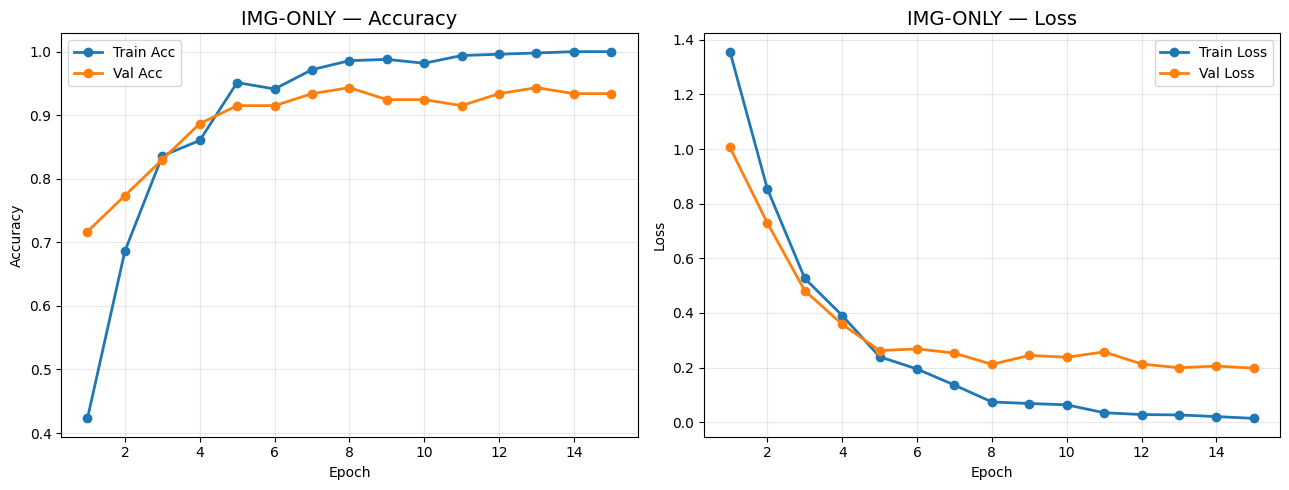


TRAIN FUSION
FUSION backbone: MobileNetV2(weights='imagenet')

Epoch |    acc% |  val_acc% |     loss |  val_loss |   best% |    time
----------------------------------------------------------------------
    1 |   48.79 |     74.53 |   1.3787 |    0.9763 |   74.53 |   179.3s
    2 |   75.71 |     83.02 |   0.8775 |    0.6347 |   83.02 |   239.8s
    3 |   85.22 |     87.74 |   0.5542 |    0.4375 |   87.74 |   298.3s
    4 |   89.68 |     86.79 |   0.3657 |    0.3520 |   87.74 |   360.1s
    5 |   93.93 |     86.79 |   0.2533 |    0.2969 |   87.74 |   421.1s
    6 |   95.95 |     91.51 |   0.1636 |    0.2559 |   91.51 |   485.3s
    7 |   96.56 |     92.45 |   0.1252 |    0.1905 |   92.45 |   546.9s
    8 |   98.99 |     95.28 |   0.0754 |    0.1714 |   95.28 |   609.6s
    9 |   99.19 |     91.51 |   0.0590 |    0.1785 |   95.28 |   673.0s
   10 |   99.60 |     91.51 |   0.0351 |    0.2023 |   95.28 |   733.0s
   11 |   98.99 |     93.40 |   0.0445 |    0.1469 |   95.28 |   794.4s
  

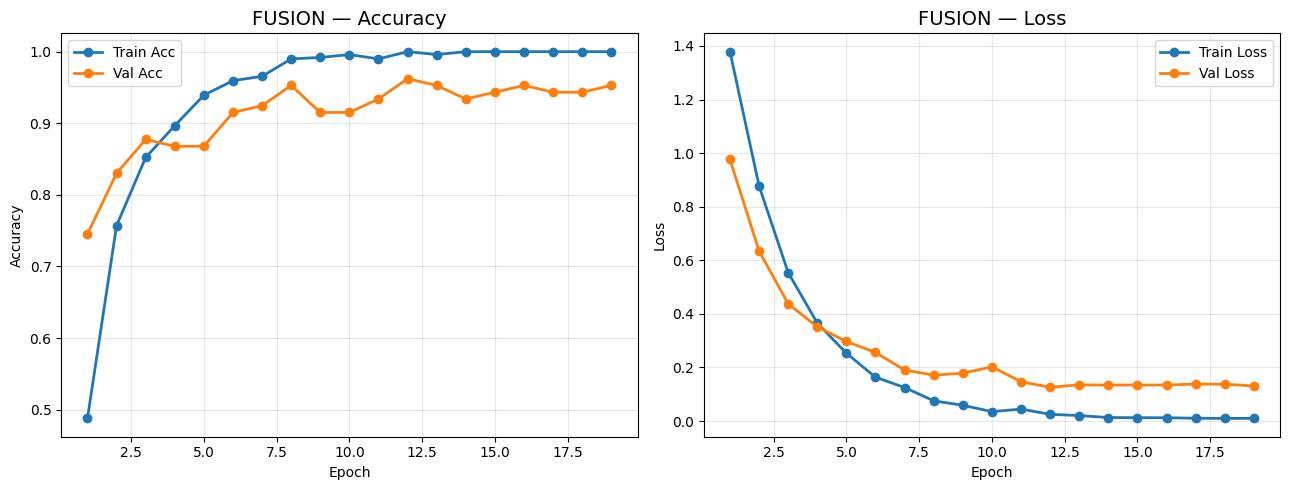

In [14]:
# ---- 1) IMG-ONLY ----
banner("TRAIN IMG-ONLY")
img_model = build_img_model()
hist_img  = train_model(
    img_model,
    train_img_ds,
    val_img_ds,
    class_weights,
    name="img_only"
)
plot_training_curves(hist_img, title="IMG-ONLY")

# ---- 2) KP-ONLY ----
# Nếu muốn train luôn thì bỏ comment 3 dòng dưới
# banner("TRAIN KP-ONLY")
# kp_model = build_kp_model()
# hist_kp  = train_model(
#     kp_model,
#     train_kp_ds,
#     val_kp_ds,
#     class_weights,
#     name="kp_only"
# )
# plot_training_curves(hist_kp, title="KP-ONLY")

# ---- 3) FUSION ----
banner("TRAIN FUSION")
fusion_model = build_fusion_model()
hist_fusion  = train_model(
    fusion_model,
    train_fusion_ds,
    val_fusion_ds,
    class_weights,
    name="fusion"
)
plot_training_curves(hist_fusion, title="FUSION")

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix_for_thesis(
    cm,
    class_names,
    title="Confusion Matrix",
    normalize=True,
    cmap="viridis",
    figsize=(5, 4),
    save_path=None
):
    cm = np.array(cm)
    if normalize:
        cm_pct = cm / cm.sum(axis=1, keepdims=True) * 100.0
        display_cm = cm_pct
        fmt = ".1f"
        cbar_label = "Accuracy (%)"
    else:
        display_cm = cm
        fmt = "d"
        cbar_label = "Count"

    plt.figure(figsize=figsize, dpi=150)
    im = plt.imshow(display_cm, interpolation="nearest", cmap=cmap, vmin=0,
                    vmax=100 if normalize else None)

    plt.title(title, fontsize=12)
    plt.xlabel("Predicted", fontsize=11)
    plt.ylabel("True", fontsize=11)

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right", fontsize=9)
    plt.yticks(tick_marks, class_names, fontsize=9)

  
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel(cbar_label, fontsize=9)

    thresh = (display_cm.max() + display_cm.min()) / 2.0
    for i in range(display_cm.shape[0]):
        for j in range(display_cm.shape[1]):
            value = display_cm[i, j]
            text_color = "white" if value > thresh else "black"
            plt.text(
                j,
                i,
                format(value, fmt),
                ha="center",
                va="center",
                color=text_color,
                fontsize=8,
            )

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Saved confusion matrix to: {save_path}")

    plt.show()


In [16]:

def evaluate_model_on_ds(build_fn, weights_path, test_ds, name="model"):
   
    model = build_fn()
    model.load_weights(weights_path)

   
    loss, acc = model.evaluate(test_ds, verbose=0)
    print(f"✅ {name} — Test acc: {acc*100:.2f}% | loss={loss:.4f}")

   
    y_true, y_pred = [], []
    for xb, yb in test_ds:
        p = model.predict(xb, verbose=0)
        y_pred.extend(np.argmax(p, axis=1))
        y_true.extend(np.argmax(yb.numpy(), axis=1))

    
    print("\n" + classification_report(y_true, y_pred,
                                       target_names=ACTIONS,
                                       digits=3))


    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(ACTIONS))))

   
    plot_confusion_matrix_for_thesis(
        cm,
        class_names=ACTIONS,
        title=f"{name} — Confusion Matrix (%)",
        normalize=True,
        figsize=(5, 4),
        save_path=f"{name.lower().replace(' ', '_')}_cm.png"  
    )

    return acc, cm




EVAL IMG-ONLY
IMG backbone: MobileNetV2(weights='imagenet')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ IMG-ONLY — Test acc: 99.06% | loss=0.0739

              precision    recall  f1-score   support

       CLIMB      1.000     1.000     1.000        13
        FALL      1.000     0.933     0.966        15
     LIEDOWN      0.938     1.000     0.968        15
         SIT      1.000     1.000     1.000        18
       STAND      1.000     1.000     1.000        45

    accuracy                          0.991       106
   macro avg      0.988     0.987     0.987       106
weighted avg      0.991     0.991     0.991       106

Saved confusion matrix to: img-only_cm.png


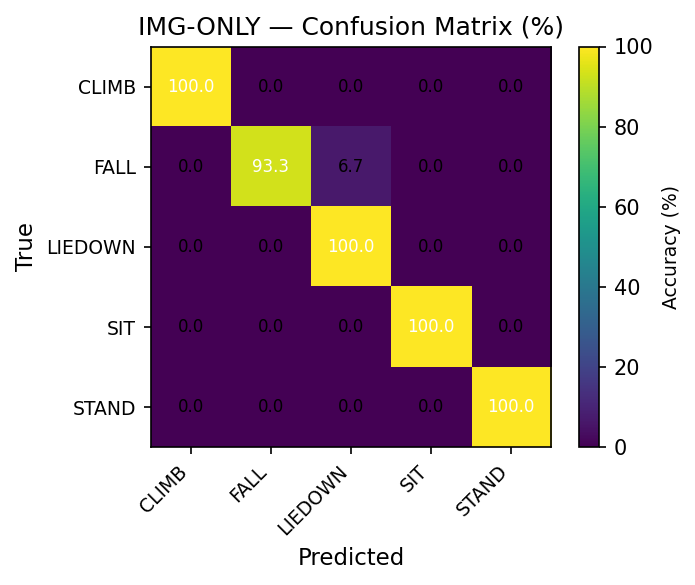


EVAL FUSION
FUSION backbone: MobileNetV2(weights='imagenet')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


✅ FUSION — Test acc: 98.11% | loss=0.0862

              precision    recall  f1-score   support

       CLIMB      1.000     1.000     1.000        13
        FALL      0.933     0.933     0.933        15
     LIEDOWN      0.938     1.000     0.968        15
         SIT      1.000     0.944     0.971        18
       STAND      1.000     1.000     1.000        45

    accuracy                          0.981       106
   macro avg      0.974     0.976     0.975       106
weighted avg      0.982     0.981     0.981       106

Saved confusion matrix to: fusion_cm.png


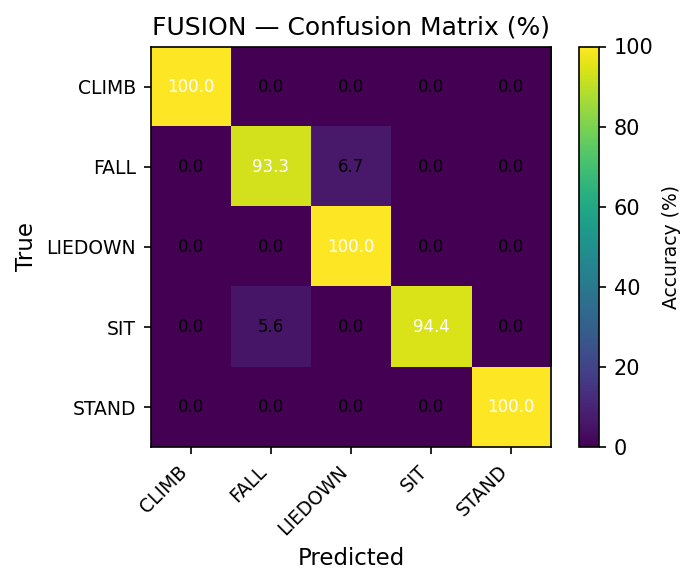


Summary Test Accuracy:
 IMG-ONLY : 99.06%
 FUSION   : 98.11%


In [17]:
# # ẢNH-
banner("EVAL IMG-ONLY")
acc_img, cm_img = evaluate_model_on_ds(
    build_img_model,
    "img_only_best.weights.h5",
    test_img_ds,
    name="IMG-ONLY"
)

# # KEYPOINT
# banner("EVAL KP-ONLY")
# acc_kp, cm_kp = evaluate_model_on_ds(
#     build_kp_model,
#     "kp_only_best.weights.h5",
#     test_kp_ds,
#     name="KP-ONLY"
# )

# FUSION
banner("EVAL FUSION")
def build_fusion_wrapper():
    return build_fusion_model()

acc_fusion, cm_fusion = evaluate_model_on_ds(
    build_fusion_wrapper,
    "fusion_best.weights.h5",
    test_fusion_ds,
    name="FUSION"
)

print("\nSummary Test Accuracy:")
print(f" IMG-ONLY : {acc_img*100:.2f}%")
# print(f"   KP-ONLY  : {acc_kp*100:.2f}%")
print(f" FUSION   : {acc_fusion*100:.2f}%")
